In [ ]:
UCI Credit Approval Dataset (Synthetic Version)

This dataset is a synthetic version of the UCI Credit Approval Dataset, originally sourced from the UCI Machine Learning Repository.
It contains 500 instances representing individuals applying for a loan or credit. Each record includes 15 attributes 
(both categorical and numerical) and a binary target variable indicating whether the application was approved (+) or denied (-).

Purpose:
The dataset is used to build and evaluate fair and transparent machine learning models for credit approval. 

Key objectives include:
 - Fairness Analysis: Ensuring the model does not discriminate based on demographic attributes.
 - Bias Mitigation: Applying techniques like reweighting and adversarial debiasing.
 - Explainability: Using SHAP or LIME to interpret predictions.

    Attribute Description:

A1: Categorical - Gender (a or b)
A2: Numerical - Age in years
A3: Numerical - Debt ratio
A4: Categorical - Employment status
A5: Categorical - Marital status
A6: Categorical - Credit history
A7: Categorical - Housing status
A8: Numerical - Loan amount
A9: Categorical - Has bank account (t or f)
A10: Categorical - Has credit card (t or f)
A11: Numerical - Number of dependents
A12: Categorical - Has previous loan defaults (t or f)
A13: Categorical - Employment type (g, p, s)
A14: Numerical - Annual income
A15: Numerical - Credit score
Approval: Target Variable (+ for approved, - for denied)

A1          0
A2          0
A3          0
A4          0
A5          0
A6          0
A7          0
A8          0
A9          0
A10         0
A11         0
A12         0
A13         0
A14         0
A15         0
Approval    1
dtype: int64


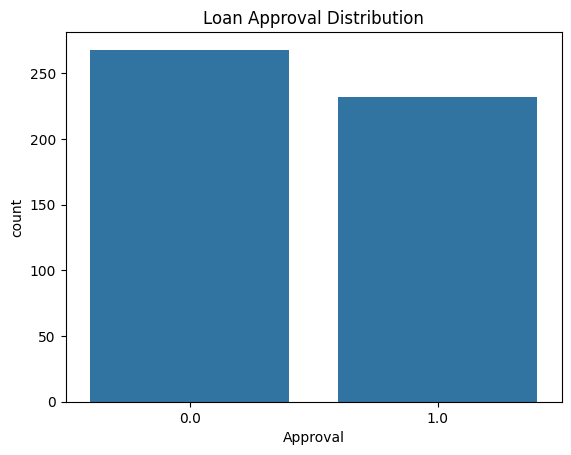

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load dataset
path = "synthetic_credit_approval.csv"
columns = ['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15', 'Approval']
df = pd.read_csv(path, names=columns, na_values='?')

# Convert target column to binary (1 = approved, 0 = rejected)
df['Approval'] = df['Approval'].map({'+': 1, '-': 0})

# Display missing values
print(df.isnull().sum())

# Visualize target distribution
sns.countplot(x=df['Approval'])
plt.title("Loan Approval Distribution")
plt.show()


In [5]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Fill missing values
imputer = SimpleImputer(strategy="most_frequent")
df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

# Encode categorical features
for col in df.select_dtypes(include=['object']).columns:
    df[col] = LabelEncoder().fit_transform(df[col])

# Scale numeric features
scaler = StandardScaler()
df[df.columns[:-1]] = scaler.fit_transform(df[df.columns[:-1]])

# Define features and target
X = df.drop("Approval", axis=1)
y = df["Approval"]

In [6]:
from fairlearn.metrics import MetricFrame, selection_rate
from fairlearn.reductions import DemographicParity

# Define protected attribute
protected_attr = df["A1"]  # Gender

# Compute selection rate per group
metric_frame = MetricFrame(metrics=selection_rate, y_true=y, y_pred=np.zeros_like(y), sensitive_features=protected_attr)
print("Selection Rate Per Group:\n", metric_frame.by_group)

Selection Rate Per Group:
 A1
-2.994629    0.0
-1.010093    0.0
 0.974443    0.0
Name: selection_rate, dtype: float64


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train models
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(n_estimators=100)
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"{name} Accuracy: {accuracy_score(y_test, y_pred):.2f}")

Logistic Regression Accuracy: 0.42
Random Forest Accuracy: 0.46


In [8]:
from fairlearn.reductions import ExponentiatedGradient

fair_model = ExponentiatedGradient(LogisticRegression(), constraints=DemographicParity())
fair_model.fit(X_train, y_train, sensitive_features=X_train['A1'])

y_pred_fair = fair_model.predict(X_test)
print("Fair Model Accuracy:", accuracy_score(y_test, y_pred_fair))

Fair Model Accuracy: 0.42574257425742573
